In [46]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import shutil
import scipy.interpolate
import math
from moviepy.editor import concatenate_videoclips, VideoFileClip

# Methods

## Hyperparameters

In [2]:
CONF_THRESH = 0.95
FPS = 30
OFFSET = 13 # cos we use window of 14 for rnn
IOU_THRESH = 0.05
FRAME_RANGE = 3
WINDOW_LEN =  6
VARIABLE_WINLEN = False

SHUTTLE_THRESH = 25

In [3]:
DOMAIN_ROOTDIR = 'domain_probs/'
RESNET_ROOTDIR = 'resnet_probs/'
LABEL_ROOTDIR = '../datasets/'

In [4]:
SHUTTLE_ROOTDIR = '../datasets/' # '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'

## Sanity check for probs file

In [5]:
npy_rootdir = 'resnet_probs/pro'
label_rootdir = '../datasets/pro'
for matchdir in os.listdir(npy_rootdir):
    for npy in os.listdir(os.path.join(npy_rootdir, matchdir)):
        basename = npy.split('_probs.npy')[0]
        label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
        prob_file = os.path.join(npy_rootdir, matchdir, npy)
        
        df_label = pd.read_csv(label_file)
        hit_labels = df_label['player_hit'].values
        
        probs = np.load(prob_file)
        
        if len(probs) != len(hit_labels):
            print(matchdir, basename, len(probs), len(hit_labels))
        

In [6]:
npy_rootdir = 'domain_probs/pro'
label_rootdir = '../datasets/pro'
for matchdir in os.listdir(npy_rootdir):
    for npy in os.listdir(os.path.join(npy_rootdir, matchdir)):
        basename = npy.split('_probs.npy')[0]
        label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
        prob_file = os.path.join(npy_rootdir, matchdir, npy)
        
        df_label = pd.read_csv(label_file)
        hit_labels = df_label['player_hit'].values
        
        probs = np.load(prob_file)
        
        if len(probs) != len(hit_labels):
            print(matchdir, basename, len(probs), len(hit_labels))
        

match3 1_08_10 127 140
match3 2_18_15 1155 1168
match3 2_10_12 213 226
match3 1_12_17 335 348
match3 2_04_07 623 636
match3 3_11_10 206 219
match3 1_01_00 440 453
test_match1 1_07_04 202 215
test_match1 1_09_07 668 681
test_match1 1_09_06 120 133
test_match1 2_03_08 133 146
test_match1 2_03_10 588 601
test_match1 1_07_06 330 343
test_match1 1_06_03 336 349
test_match1 2_02_07 142 155
test_match1 1_07_03 674 687
test_match1 1_05_03 382 395
test_match1 1_05_02 504 517
match23 2_07_03 570 583
match23 1_06_04 514 527
match23 2_12_08 516 529
match23 1_17_13 532 545
match23 1_11_08 568 581
match23 2_02_03 314 327
match4 2_05_07 392 405
match4 2_02_05 463 476
match4 1_15_10 389 402
match4 1_03_02 345 358
match4 2_14_17 184 197
match4 3_18_17 543 556
match4 3_07_05 154 167
match4 3_02_00 341 354
match10 2_14_08 739 752
match10 2_04_02 322 335
match10 1_12_16 468 481
match10 1_03_01 567 580
match10 1_03_03 512 525
match2 1_06_08 341 354
match2 1_00_02 598 611
match2 1_02_03 346 359
match2 1_04_

## Optimisation algorithms

In [7]:
# memo[numframes][3]. i.e. memo[f][0] stores the score when label 0 is assigned to current frame f, tgt with hitlabels, numhits
NEGNUM = -100000
# returns score, hit labels, numhits
def maximise_hit_score(hit_probs, fps, window_len=WINDOW_LEN, variable_winlen=False): # takes in prediction probabiltiies for each frame
    tau = np.mean(np.array([np.mean(hit_probs[:,1]), np.mean(hit_probs[:,2])])) # turns some probs to negative to encourage less than T hits
    
    fnum = len(hit_probs)
    if fnum == 1: # base case
        return np.amax(hit_probs), [np.argmax(hit_probs)], 1 if np.argmax(hit_probs) != 0 else 0
    
    # init memoisation table
    memo = {}
    memo[0] = {}
    memo[0][0] = (0, [0], 0) # force no hit detections on first frame
    memo[0][1] = (NEGNUM, [], 0)
    memo[0][2] = (NEGNUM, [], 0)
    
    for f in range(1,fnum):
        memo[f] = {}
        
        # get frame indices of positive hit labels 
        positive_hit_labels0 = [(i, label) for i, label in enumerate(memo[f-1][0][1]) if label != 0]
        last_positive_hit_label0 = (0,0) if len(positive_hit_labels0)==0 else positive_hit_labels0[-1]
        
        # assigning hit0 to current frame
        memo[f][0] = max([ (memo[f-1][0][0], memo[f-1][0][1]+[0], memo[f-1][0][2]), \
                           (memo[f-1][1][0], memo[f-1][1][1]+[0], memo[f-1][1][2]), \
                           (memo[f-1][2][0], memo[f-1][2][1]+[0], memo[f-1][2][2]) ], key=lambda x: x[0]) # max score
        
        # for enforcing number of hits smaller than numsecs, and encouraging detection of more hits to hit this target
        maxhits_allowed = math.ceil(f/fps) + 1
        
        # 3 constraints: (1) consec hits must be 0.5s apart, (2) numhits < numsecs, (3) hits must alternate between players
        satisfy_constraints0_1 = (f - last_positive_hit_label0[0] > 0.5*fps) and (memo[f-1][0][2] <= maxhits_allowed) and (last_positive_hit_label0[1] != 1)
        satisfy_constraints0_2 = (f - last_positive_hit_label0[0] > 0.5*fps) and (memo[f-1][0][2] <= maxhits_allowed) and (last_positive_hit_label0[1] != 2)
        
        smallest_winlen = 1 if variable_winlen else window_len
        # assigning hit1 to current frame, setting previous five frames to hits to ensure window of six hits consecutively
        if satisfy_constraints0_1 and f >= window_len:
            # scores for diff win length
            diff_win_tuples = []
            for i in range(smallest_winlen, window_len+1):
                diff_win_tuples.append((memo[f-i][0][0] + np.sum(hit_probs[f-i+1:f+1,1]) - i*tau, \
                                        memo[f-i][0][1]+[1]*i, \
                                        memo[f-1][0][2]+1))
                
            memo[f][1] = max(diff_win_tuples, key=lambda x: x[0])
        else:
            memo[f][1] = (NEGNUM, [], 0) # assign large negative number so that this will not be in optimal sequence
        
        # assigning hit2 to current frame
        if satisfy_constraints0_2 and f >= window_len:
            # scores for diff win length
            diff_win_tuples = []
            for i in range(smallest_winlen, window_len+1):
                diff_win_tuples.append((memo[f-i][0][0] + np.sum(hit_probs[f-i+1:f+1,2]) - i*tau, \
                                        memo[f-i][0][1]+[2]*i, \
                                        memo[f-1][0][2]+1))
                
            memo[f][2] = max(diff_win_tuples, key=lambda x: x[0])
        else:
            memo[f][2] = (NEGNUM, [], 0) # assign large negative number so that this will not be in optimal sequence
            
    return np.array(memo[fnum-1][0][1]).astype('int') # for sure last frame would be no hit

In [8]:
def optimise_hits_naive(hit_preds, fps=FPS, frame_range=FRAME_RANGE): # takes in predicted labels for each frame
    
    # check if hit predictions are in the form of labels, or frame indices
    if all(h in [0,1,2] for h in hit_preds):
        frames_hit = np.where(np.array(hit_preds) > 0)[0]
        tot_frames = len(hit_preds)
        is_predindices = False
    else:
        frames_hit = hit_preds
        tot_frames = 0 if len(hit_preds) == 0 else hit_preds[-1]
        is_predindices = True
    
    # ensure no two hits are within 0.5s of each other
    min_frames_apart = int(fps/2)
    out_pred = np.zeros(tot_frames)
    if len(frames_hit) > 0:
        frames_filtered = []
        frames_filtered.append(frames_hit[0])
        frame_ref = frames_hit[0]
        for i in range(1, len(frames_hit)):
            if frames_hit[i] > frame_ref + min_frames_apart:
                frames_filtered.append(frames_hit[i])
                frame_ref = frames_hit[i]

        for i in range(len(frames_filtered)):
            frame_hit = frames_filtered[i]
            out_pred[frame_hit-frame_range:frame_hit+frame_range+1] = 1 if is_predindices else hit_preds[frame_hit]
    
    return out_pred.astype('int')

## Rule-based shuttlecock algo

In [9]:
def interpolate_and_differentiate(shuttle_file):
    df_shuttle = pd.read_csv(shuttle_file)
    
    frame_ind = df_shuttle['Frame'].values
    shuttle_coords = df_shuttle[['X', 'Y']].to_numpy()

    shuttle_frame = []
    for i in range(len(frame_ind)):
        if np.any(shuttle_coords[i]):
            shuttle_frame.append([i, shuttle_coords[i][0], shuttle_coords[i][1]])
    shuttle_frame = np.array(shuttle_frame)

    # interpolation to get 2nd derivative
    spl_y = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,2], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
    y = scipy.interpolate.splev(frame_ind, spl_y, der=0)
    ddy = scipy.interpolate.splev(frame_ind, spl_y, der=2) # use those knots to get second derivative 
    spl_x = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,1], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
    x = scipy.interpolate.splev(frame_ind, spl_x, der=0)
    ddx = scipy.interpolate.splev(frame_ind, spl_x, der=2) # use those knots to get second derivative
    
    return x, y, ddx, ddy

                
def detect_hit_frames(shuttle_file, thresh=SHUTTLE_THRESH, fps=FPS):
    x, y, ddx, ddy = interpolate_and_differentiate(shuttle_file)
    detected_frames = np.unique(np.concatenate((np.where(ddx>thresh)[0], np.where(ddy>thresh)[0]), axis=0))
    
    pred_labels = optimise_hits_naive(detected_frames, fps=fps, frame_range=FRAME_RANGE)
                
    return pred_labels

## Functions to process probabilities

In [10]:
def domain_probs2labels(probfile, opt='max', conf_thresh=CONF_THRESH):
    probs = np.load(probfile)
    
    if opt=='max':
        pred_labels = maximise_hit_score(probs, FPS, window_len=WINDOW_LEN, variable_winlen=VARIABLE_WINLEN)
    else:
        pred_labels = []
        for prob in probs:
            if np.amax(prob) > conf_thresh:
                pred_labels.append(np.argmax(prob))
            else:
                pred_labels.append(0)
                
        if opt=='naive':
            pred_labels = optimise_hits_naive(pred_labels, fps=FPS)
      
    return pred_labels


def resnet_probs2labels(probfile, opt='naive', conf_thresh=CONF_THRESH):
    probs = np.load(probfile) # note that there are 2 sets of probs, one for each player

    if opt == 'max':
        probs_agg = probs[:, [0,1,5]] # hit0 not impt, hit1 of player1 (near), hit2 of player2 (far)
        pred_labels = maximise_hit_score(probs_agg, FPS)
    else:
        pred_labels = []
        
        for prob in probs:
            prob1 = prob[:3]
            prob2 = prob[3:]

            label1, conf1 = np.argmax(prob1), np.amax(prob1)
            label2, conf2 = np.argmax(prob2), np.amax(prob2)

            assigned_label = 0
            if (label1 == 1 and label2 == 0) or (label1 == 1 and label2 == 1):
                if conf1 > conf_thresh:
                    assigned_label = 1
            elif (label1 == 0 and label2 == 2) or (label1 == 2 and label2 == 2):
                if conf2 > conf_thresh:
                    assigned_label = 2

            pred_labels.append(assigned_label)

        if opt == 'naive':
            pred_labels = optimise_hits_naive(pred_labels, fps=FPS)
    
    return np.array(pred_labels)


def gtfile2labels(labelfile):
    df_label = pd.read_csv(labelfile)
    hit_labels = df_label['player_hit'].values
    return hit_labels

## Sample processing of probabilities

### Process probs from domain-rnn
OK, practically perfect on pro dataset, as before.

In [11]:
# input file directory names
matchdir = 'test_match1'
basename = '2_02_07' # '1_05_02' #'2_02_07'
prefix = 'pro'

npy = basename + '_probs.npy'
label_file = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
probfile = os.path.join(DOMAIN_ROOTDIR, prefix, matchdir, npy)

pred_labels = domain_probs2labels(probfile, opt='none', conf_thresh=CONF_THRESH)
hit_labels = gtfile2labels(label_file)
        
pred_labels1 = optimise_hits_naive(pred_labels, fps=FPS)
pred_labels2 = domain_probs2labels(probfile, opt='max', conf_thresh=CONF_THRESH)
print("GT")
print(np.where(hit_labels[OFFSET:] > 0))
print("no opt")
print(np.where(np.array(pred_labels) > 0))
print("naive opt")
print(np.where(pred_labels1 > 0))
print("max opt")
print(np.where(pred_labels2 > 0))

GT
(array([21, 42, 58, 78, 88]),)
no opt
(array([ 0, 22, 23, 24, 25, 26, 42, 43, 44, 45, 46, 47, 48, 59, 60, 61, 62,
       63, 78, 79, 80, 81, 82, 89, 90, 91]),)
naive opt
(array([19, 20, 21, 22, 23, 24, 25, 39, 40, 41, 42, 43, 44, 45, 56, 57, 58,
       59, 60, 61, 62, 75, 76, 77, 78, 79, 80, 81]),)
max opt
(array([ 12,  13,  14,  15,  16,  17,  38,  39,  40,  41,  42,  43,  55,
        56,  57,  58,  59,  60,  74,  75,  76,  77,  78,  79,  90,  91,
        92,  93,  94,  95, 114, 115, 116, 117, 118, 119]),)


### Process probs from ResNet

In [12]:
# input file directory names
matchdir = 'test_match1'
basename = '2_02_07' #'1_05_02' #'2_02_07'
prefix = 'pro'

npy = basename + '_probs.npy'
label_file = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
probfile = os.path.join(RESNET_ROOTDIR, prefix, matchdir, npy)

pred_labels = resnet_probs2labels(probfile, opt='none', conf_thresh=CONF_THRESH)
pred_labels1 = optimise_hits_naive(pred_labels, fps=FPS)
pred_labels2 = resnet_probs2labels(probfile, opt='max', conf_thresh=CONF_THRESH)
hit_labels = gtfile2labels(label_file)


print('GT')
print(np.where(hit_labels > 0))
print('no opt')
print(np.where(np.array(pred_labels) > 0))
print('naive opt')
print(np.where(np.array(pred_labels1) > 0))
print('max opt')
print(np.where(np.array(pred_labels2) > 0))

GT
(array([ 34,  55,  71,  91, 101]),)
no opt
(array([ 30,  33,  35,  37,  39,  41,  42,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  65,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  97,  98,  99, 100, 101, 102, 105, 106, 110, 111,
       112, 113, 114, 115, 116, 120]),)
naive opt
(array([ 27,  28,  29,  30,  31,  32,  33,  47,  48,  49,  50,  51,  52,
        53,  64,  65,  66,  67,  68,  69,  70,  80,  81,  82,  83,  84,
        85,  86,  96,  97,  98,  99, 100, 101, 102, 112, 113, 114, 115,
       116, 117, 118]),)
max opt
(array([25, 26, 27, 28, 29, 30, 41, 42, 43, 44, 45, 46, 59, 60, 61, 62, 63,
       64, 76, 77, 78, 79, 80, 81, 93, 94, 95, 96, 97, 98]),)


### Process doubles

In [13]:
# input file directory names
matchdir = 'match_msia'
basename = 'doubles0'
prefix = 'am_doubles'
opt = 'naive'

labelfile = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
probfile1 = os.path.join(DOMAIN_ROOTDIR, prefix, matchdir, basename + '_pair1_probs.npy')
probfile2 = os.path.join(DOMAIN_ROOTDIR, prefix, matchdir, basename + '_pair2_probs.npy')

pred_labels1 = domain_probs2labels(probfile1, opt=opt, conf_thresh=CONF_THRESH)
pred_labels2 = domain_probs2labels(probfile2, opt=opt, conf_thresh=CONF_THRESH)
pred_labels = []
for i in range(len(pred_labels1)):
    y1, y2 = pred_labels1[i], pred_labels2[i]
    if (y1 == 1 and y2 == 0) or (y1 == 0 and y2 == 1) or (y1 == 1 and y2 == 1):
        pred_labels.append(1)
    elif (y1 == 2 and y2 == 0) or (y1 == 0 and y2 == 2)  or (y1 == 2 and y2 == 2):
        pred_labels.append(2)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)
        
hit_labels = gtfile2labels(labelfile)

print('GT')
print(np.where(hit_labels[OFFSET:]>0))
print('predicted')
print(np.where(pred_labels>0))

GT
(array([  1,  20,  53,  61,  87, 113, 150, 187, 221, 234, 277, 309, 342,
       381, 398, 417, 443, 480, 491, 511, 536, 572, 609, 635, 702, 722]),)
predicted
(array([  8,   9,  10,  11,  12,  13,  14,  22,  23,  24,  29,  30,  31,
        60,  61,  62,  63,  67,  68,  69,  70,  84,  85,  86,  87,  88,
        89,  90, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 188, 189, 190, 191, 192, 193, 194, 195, 233, 234, 235,
       236, 240, 241, 242, 243, 265, 266, 267, 268, 269, 270, 271, 281,
       282, 283, 284, 285, 286, 287, 297, 298, 299, 300, 301, 302, 303,
       315, 316, 317, 318, 319, 320, 321, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 380, 381, 382, 383, 384, 385, 386, 401,
       402, 403, 404, 405, 406, 407, 436, 437, 438, 439, 440, 441, 443,
       444, 445, 446, 447, 448, 457, 458, 459, 460, 461, 462, 463, 481,
       482, 483, 484, 485, 486, 487, 493, 494, 495, 496, 497, 498, 499,
       539, 540, 541, 542, 543, 544, 545, 569,

# Evaluation

Use mAP. And AP for each hit label.

TP defined as predicted and gt time windows having IOU_T > IOU_THRESH.

Precision is per video, per hit label type. TP / (number of windows predicted)

Average Precision is across all videos, per hit label type. Sum(Precision) / (Num videos)

mean Average Precision is mean of AP across both hit labels. mAP = mean(AP1 + AP2)

In [14]:
def expand_label_frame_range(gt_label, frame_range=FRAME_RANGE):
    # expand gt hit labels into a window of labels
    orig = gt_label.copy()
    for i in range(len(orig)):
        if orig[i] != 0:
            gt_label[i-frame_range:i+frame_range+1] = orig[i]
    
    return gt_label

def preds2seframes(preds, target_class):
    frames_se = []
    frames_hit = np.where(preds == target_class)[0]
    
    if len(frames_hit) > 0:
        start_frame = frames_hit[0]
        for i in range(1, len(frames_hit)):
            if frames_hit[i] != frames_hit[i-1] + 1:
                end_frame = frames_hit[i-1]
                frames_se.append((start_frame, end_frame))
                start_frame = frames_hit[i]

    return frames_se

def timewin_intersection_over_union(timewinA, timewinB):
    # determine the framenums of the intersection rectangle
    frameA = max(timewinA[0], timewinB[0])
    frameB = min(timewinA[1], timewinB[1])
    
    # compute length of intersection
    interLength = max(0, frameB - frameA + 1)
    
    # compute length of union
    lenA = timewinA[1] - timewinA[0] + 1
    lenB = timewinB[1] - timewinB[0] + 1
    unionLength = float(lenA + lenB - interLength)
    
    iou = interLength / unionLength
    
    return iou

def calc_metrics(frames_se_gt, frames_se_pred, iou_thresh=IOU_THRESH):
    tp = 0
    min_j = 0
    for i in range(len(frames_se_pred)):
        timewin_pred = frames_se_pred[i]
        for j in range(min_j, len(frames_se_gt)):
            timewin_gt = frames_se_gt[j]
            t_iou = timewin_intersection_over_union(timewin_pred, timewin_gt)
            if t_iou > iou_thresh:
                tp += 1
                min_j = j
                break
    fp = len(frames_se_pred) - tp
    fn = len(frames_se_gt) - tp

    
    # settle edge cases, -1 stands for NA
    if tp + fp + fn == 0:
        precision, recall, f1 = 1,1,1
    elif tp + fn == 0: # false positives exist
        precision, recall, f1 = 0, -1, 0
    elif tp + fp == 0: # false negatives exist
        precision, recall, f1 = -1, 0, 0
    else:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision*recall) / (precision + recall)
    
    return precision, recall, f1


# returns precision (array of size 2) of temporal proposals for each target class, for each video
def eval_vid_metrics(gt_label, pred_label, frame_range=FRAME_RANGE, iou_thresh=IOU_THRESH):
    gt_label = np.array(gt_label)
    pred_label = np.array(pred_label)
    
    # expand gt hit labels into a window of labels
    gt_label = expand_label_frame_range(gt_label, frame_range=frame_range)
    
    metrics = {}
    metrics['precision'] = np.zeros(2)
    metrics['recall'] = np.zeros(2)
    metrics['f1'] = np.zeros(2)
    for k, target_class in enumerate([1,2]):
        # get start, end frames for each proposed time window of hit
        frames_se_gt = preds2seframes(gt_label, target_class)
        frames_se_pred = preds2seframes(pred_label, target_class)
        
        # calculate metrics
        prec, rec, f1 = calc_metrics(frames_se_gt, frames_se_pred, iou_thresh=iou_thresh)
        metrics['precision'][k] = prec
        metrics['recall'][k] = rec
        metrics['f1'][k] = f1
        
    return metrics

In [15]:
def calc_overall_metrics(df):
    overall_metrics = {}
    overall_metrics['AP_1'] = np.mean(df[df['P1'] != -1]['P1'].values)
    overall_metrics['AP_2'] = np.mean(df[df['P2'] != -1]['P2'].values)
    overall_metrics['mAP'] = (overall_metrics['AP_1'] + overall_metrics['AP_2']) / 2
    
    overall_metrics['AR_1'] = np.mean(df[df['R1'] != -1]['R1'].values)
    overall_metrics['AR_2'] = np.mean(df[df['R2'] != -1]['R2'].values)
    overall_metrics['mAR'] = (overall_metrics['AR_1'] + overall_metrics['AR_2']) / 2
    
    overall_metrics['AF_1'] = np.mean(df['F1'].values)
    overall_metrics['AF_2'] = np.mean(df['F2'].values)
    overall_metrics['mAF'] = (overall_metrics['AF_1'] + overall_metrics['AF_2']) / 2
    
    return overall_metrics
    

def eval_dataset(rootdir=DOMAIN_ROOTDIR, iou_thresh=IOU_THRESH, prefix='pro', opt='naive', doubles=False):
    rows_list = []
    for matchdir in sorted(os.listdir(os.path.join(rootdir, prefix))):
        if prefix == 'pro':
            is_testdir = 'test' in matchdir
        else:
            is_testdir = True
        if is_testdir:
            if 'domain' in rootdir or 'resnet' in rootdir:
                for npy in sorted(os.listdir(os.path.join(rootdir, prefix, matchdir))):
                
                    if not doubles:
                        basename = npy.split('_probs.npy')[0]
                        labelfile = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
                        probfile = os.path.join(rootdir, prefix, matchdir, npy)

                        if rootdir == RESNET_ROOTDIR:
                            pred_labels = resnet_probs2labels(probfile, opt=opt, conf_thresh=CONF_THRESH)
                        elif rootdir == DOMAIN_ROOTDIR:
                            pred_labels = domain_probs2labels(probfile, opt=opt, conf_thresh=CONF_THRESH)

                    else: # doubles, need to handle each near-far pair
                        basename_pair = npy.split('_probs.npy')[0]
                        basename = basename_pair.split('_pair')[0]
                        labelfile = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
                        probfile1 = os.path.join(rootdir, prefix, matchdir, npy)
                        probfile2 = os.path.join(rootdir, prefix, matchdir, basename + '_pair2_probs.npy')

                        if rootdir == RESNET_ROOTDIR:
                            pred_labels1 = resnet_probs2labels(probfile1, opt=opt, conf_thresh=CONF_THRESH)
                            pred_labels2 = resnet_probs2labels(probfile2, opt=opt, conf_thresh=CONF_THRESH)
                        elif rootdir == DOMAIN_ROOTDIR:
                            pred_labels1 = domain_probs2labels(probfile1, opt=opt, conf_thresh=CONF_THRESH)
                            pred_labels2 = domain_probs2labels(probfile2, opt=opt, conf_thresh=CONF_THRESH)
                        pred_labels = []
                        for i in range(len(pred_labels1)):
                            y1, y2 = pred_labels1[i], pred_labels2[i]
                            if (y1 == 1 and y2 == 0) or (y1 == 0 and y2 == 1) or (y1 == 1 and y2 == 1):
                                pred_labels.append(1)
                            elif (y1 == 2 and y2 == 0) or (y1 == 0 and y2 == 2)  or (y1 == 2 and y2 == 2):
                                pred_labels.append(2)
                            else:
                                pred_labels.append(0)
                                
                    gt_labels = gtfile2labels(labelfile)
                    gt_labels = gt_labels[OFFSET:] # offset because domain predictions lose the first 13 frames
                    if rootdir==RESNET_ROOTDIR:
                        pred_labels = pred_labels[OFFSET:]

                    metrics = eval_vid_metrics(gt_labels, pred_labels, frame_range=FRAME_RANGE, iou_thresh=iou_thresh)

                    row_dict = {}
                    row_dict['match'] = matchdir
                    row_dict['vid'] = basename
                    row_dict['P1'] = metrics['precision'][0]
                    row_dict['P2'] = metrics['precision'][1]
                    row_dict['R1'] = metrics['recall'][0]
                    row_dict['R2'] = metrics['recall'][1]
                    row_dict['F1'] = metrics['f1'][0]
                    row_dict['F2'] = metrics['f1'][1]
                    rows_list.append(row_dict.copy())
                                
            else: # shuttle rule-based
                for shuttlecsv in sorted(os.listdir(os.path.join(rootdir, prefix, matchdir, 'ball_trajectory'))):
                    if shuttlecsv.endswith('csv'):
                        basename = shuttlecsv.split('_ball.csv')[0]
                        labelfile = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
                        shuttle_file = os.path.join(rootdir, prefix, matchdir, 'ball_trajectory', shuttlecsv)

                        # get predicted and true hit frames
                        pred_labels = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)

                        gt_labels = gtfile2labels(labelfile)
                        gt_labels = gt_labels[OFFSET:] # offset because domain predictions lose the first 13 frames
                        pred_labels = pred_labels[OFFSET:]

                        metrics = eval_vid_metrics(gt_labels, pred_labels, frame_range=FRAME_RANGE, iou_thresh=iou_thresh)

                        row_dict = {}
                        row_dict['match'] = matchdir
                        row_dict['vid'] = basename
                        row_dict['P1'] = metrics['precision'][0]
                        row_dict['P2'] = metrics['precision'][1]
                        row_dict['R1'] = metrics['recall'][0]
                        row_dict['R2'] = metrics['recall'][1]
                        row_dict['F1'] = metrics['f1'][0]
                        row_dict['F2'] = metrics['f1'][1]
                        rows_list.append(row_dict.copy())
               

    df = pd.DataFrame(rows_list)
    overall_metrics = calc_overall_metrics(df)
    
    
    return df, overall_metrics

## Sample evaluation

In [16]:
prefix = 'pro'
opt = 'naive'

df_naive_domain_pro, metrics = eval_dataset(rootdir=DOMAIN_ROOTDIR, prefix=prefix, opt=opt)

print(metrics)
df_naive_domain_pro.describe()

{'AP_1': 0.919824520717378, 'AP_2': 0.9645342312008978, 'mAP': 0.9421793759591379, 'AR_1': 0.9704635642135643, 'AR_2': 0.842812049062049, 'mAR': 0.9066378066378067, 'AF_1': 0.9424224116017138, 'AF_2': 0.871913258056846, 'mAF': 0.90716783482928}


,P1,P2,R1,R2,F1,F2
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.919825,0.894372,0.970464,0.842812,0.942422,0.871913
std,0.120126,0.380858,0.098471,0.233038,0.102524,0.200920
min,0.500000,-1.000000,0.500000,0.000000,0.500000,0.000000
25%,0.857143,1.000000,1.000000,0.787500,0.919580,0.800000
50%,1.000000,1.000000,1.000000,0.954545,1.000000,0.946779
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## performance at different IOU_THRESH

In [17]:
list_thresh = np.around(np.arange(15)*0.05, 2)

methods = [ 'rulebased', 'domain', 'resnet'] 
opts = ['max', 'naive', 'none']
testsets = ['pro', 'am_singles', 'am_doubles']

results_dict = {}
for thresh in list_thresh:
    results_dict[thresh] = {}
    for method in methods:
        results_dict[thresh][method] = {}
        rootdir = DOMAIN_ROOTDIR if 'domain' in method else RESNET_ROOTDIR if 'resnet' in method else SHUTTLE_ROOTDIR
        
        for testset in testsets:
            results_dict[thresh][method][testset] = {}
            is_doubles = True if 'double' in testset else False
            
            for opt in opts:
                results_dict[thresh][method][testset][opt] = {}
          
                df, metrics = eval_dataset(rootdir=rootdir, iou_thresh=thresh, prefix=testset, opt=opt, doubles=is_doubles)
                results_dict[thresh][method][testset][opt]['metrics'] = metrics
                results_dict[thresh][method][testset][opt]['df'] = df

print(results_dict.keys())

/home/ykw/anaconda3/envs/playerbbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ykw/anaconda3/envs/playerbbox/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dict_keys([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])


### Domain vs ResNet vs Rule-based

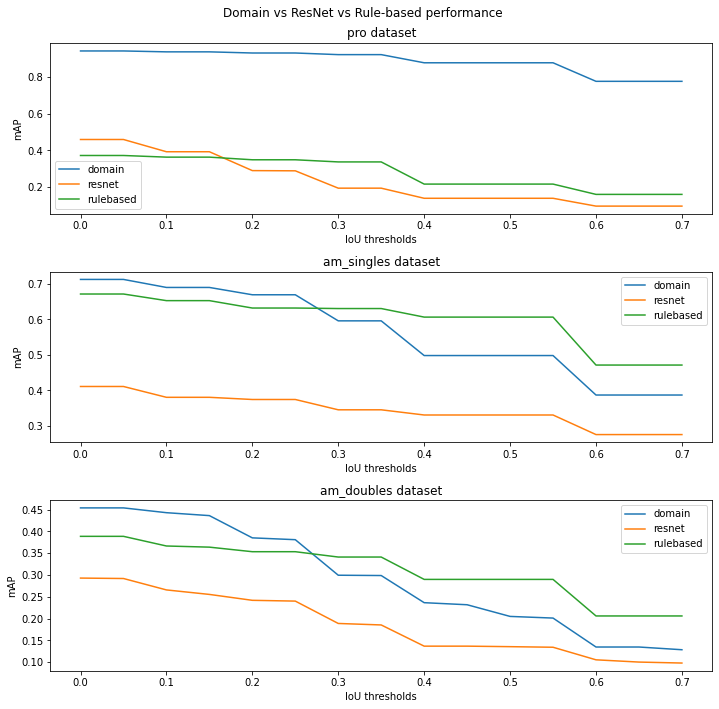

In [18]:
domain_naive_pro = np.zeros(len(list_thresh))
resnet_naive_pro = np.zeros(len(list_thresh))
rule_naive_pro = np.zeros(len(list_thresh))

domain_naive_am_singles = np.zeros(len(list_thresh))
resnet_naive_am_singles = np.zeros(len(list_thresh))
rule_naive_am_singles = np.zeros(len(list_thresh))

domain_naive_am_doubles = np.zeros(len(list_thresh))
resnet_naive_am_doubles = np.zeros(len(list_thresh))
rule_naive_am_doubles = np.zeros(len(list_thresh))

for i, thresh in enumerate(list_thresh):
    domain_naive_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['mAP']
    resnet_naive_pro[i] = results_dict[thresh]['resnet']['pro']['naive']['metrics']['mAP']
    rule_naive_pro[i] = results_dict[thresh]['rulebased']['pro']['naive']['metrics']['AP_1']
    
    domain_naive_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['mAP']
    resnet_naive_am_singles[i] = results_dict[thresh]['resnet']['am_singles']['naive']['metrics']['mAP']
    rule_naive_am_singles[i] = results_dict[thresh]['rulebased']['am_singles']['naive']['metrics']['AP_1']
    
    domain_naive_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['mAP']
    resnet_naive_am_doubles[i] = results_dict[thresh]['resnet']['am_doubles']['naive']['metrics']['mAP']
    rule_naive_am_doubles[i] = results_dict[thresh]['rulebased']['am_doubles']['naive']['metrics']['AP_1']


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
fig.suptitle('Domain vs ResNet vs Rule-based performance')
ax1.plot(list_thresh, domain_naive_pro, label='domain')
ax1.plot(list_thresh, resnet_naive_pro, label='resnet')
ax1.plot(list_thresh, rule_naive_pro, label='rulebased')
ax1.set_title('pro dataset')
ax1.set_xlabel('IoU thresholds')
ax1.set_ylabel('mAP')
ax1.legend()

ax2.plot(list_thresh, domain_naive_am_singles, label='domain')
ax2.plot(list_thresh, resnet_naive_am_singles, label='resnet')
ax2.plot(list_thresh, rule_naive_am_singles, label='rulebased')
ax2.set_title('am_singles dataset')
ax2.set_xlabel('IoU thresholds')
ax2.set_ylabel('mAP')
ax2.legend()

ax3.plot(list_thresh, domain_naive_am_doubles, label='domain')
ax3.plot(list_thresh, resnet_naive_am_doubles, label='resnet')
ax3.plot(list_thresh, rule_naive_am_doubles, label='rulebased')
ax3.set_title('am_doubles dataset')
ax3.set_xlabel('IoU thresholds')
ax3.set_ylabel('mAP')
ax3.legend()

plt.tight_layout()

plt.show()

In [28]:
thresh = 0.2
print('Domain, pro, naive, iou 0.2', results_dict[thresh]['domain']['pro']['naive']['metrics'])
print('ResNet, pro, naive, iou 0.2', results_dict[thresh]['resnet']['pro']['naive']['metrics'])
print('Rulesbased, pro, naive, iou 0.2', results_dict[thresh]['rulebased']['pro']['naive']['metrics'])

print('Domain, am-singles, naive, iou 0.2', results_dict[thresh]['domain']['am_singles']['naive']['metrics'])
print('ResNet, am-singles, naive, iou 0.2', results_dict[thresh]['resnet']['am_singles']['naive']['metrics'])
print('Rulesbased, am-singles, naive, iou 0.2', results_dict[thresh]['rulebased']['am_singles']['naive']['metrics'])

print('Domain, am_doubles, naive, iou 0.2', results_dict[thresh]['domain']['am_doubles']['naive']['metrics'])
print('ResNet, am_doubles, naive, iou 0.2', results_dict[thresh]['resnet']['am_doubles']['naive']['metrics'])
print('Rulesbased, am_doubles, naive, iou 0.2', results_dict[thresh]['rulebased']['am_doubles']['naive']['metrics'])

Domain, pro, naive, iou 0.2 {'AP_1': 0.9096204390847248, 'AP_2': 0.9524971941638609, 'mAP': 0.9310588166242928, 'AR_1': 0.9580176767676767, 'AR_2': 0.8320256132756132, 'mAR': 0.8950216450216449, 'AF_1': 0.9312136203929225, 'AF_2': 0.8607387882689308, 'mAF': 0.8959762043309267}
ResNet, pro, naive, iou 0.2 {'AP_1': 0.24374923576849958, 'AP_2': 0.33659554730983304, 'mAP': 0.2901723915391663, 'AR_1': 0.4057012432012432, 'AR_2': 0.4694689754689755, 'mAR': 0.4375851093351093, 'AF_1': 0.28352355281970837, 'AF_2': 0.3701466858719914, 'mAF': 0.32683511934584986}
Rulesbased, pro, naive, iou 0.2 {'AP_1': 0.34918224555905714, 'AP_2': 1.0, 'mAP': 0.6745911227795286, 'AR_1': 0.4325637325637326, 'AR_2': 0.10714285714285714, 'mAR': 0.26985329485329485, 'AF_1': 0.3566935464103657, 'AF_2': 0.10714285714285714, 'mAF': 0.23191820177661143}
Domain, am-singles, naive, iou 0.2 {'AP_1': 0.7769717261904762, 'AP_2': 0.5622562358276644, 'mAP': 0.6696139810090702, 'AR_1': 0.6414574314574315, 'AR_2': 0.76343005952

### Pro vs am-singles vs am-doubles

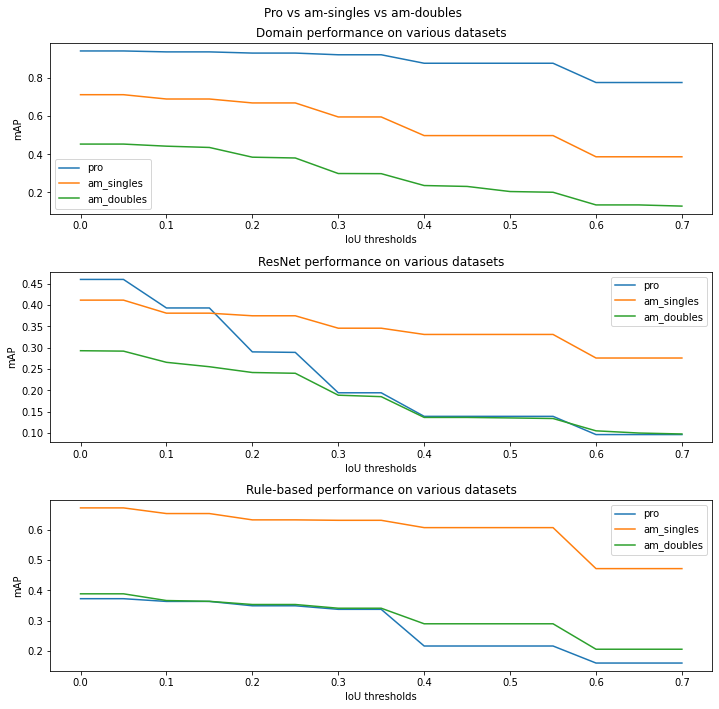

In [19]:
domain_naive_pro = np.zeros(len(list_thresh))
resnet_naive_pro = np.zeros(len(list_thresh))
rule_naive_pro = np.zeros(len(list_thresh))

domain_naive_am_singles = np.zeros(len(list_thresh))
resnet_naive_am_singles = np.zeros(len(list_thresh))
rule_naive_am_singles = np.zeros(len(list_thresh))

domain_naive_am_doubles = np.zeros(len(list_thresh))
resnet_naive_am_doubles = np.zeros(len(list_thresh))
rule_naive_am_doubles = np.zeros(len(list_thresh))

for i, thresh in enumerate(list_thresh):
    domain_naive_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['mAP']
    resnet_naive_pro[i] = results_dict[thresh]['resnet']['pro']['naive']['metrics']['mAP']
    rule_naive_pro[i] = results_dict[thresh]['rulebased']['pro']['naive']['metrics']['AP_1']
    
    domain_naive_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['mAP']
    resnet_naive_am_singles[i] = results_dict[thresh]['resnet']['am_singles']['naive']['metrics']['mAP']
    rule_naive_am_singles[i] = results_dict[thresh]['rulebased']['am_singles']['naive']['metrics']['AP_1']
    
    domain_naive_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['mAP']
    resnet_naive_am_doubles[i] = results_dict[thresh]['resnet']['am_doubles']['naive']['metrics']['mAP']
    rule_naive_am_doubles[i] = results_dict[thresh]['rulebased']['am_doubles']['naive']['metrics']['AP_1']


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
fig.suptitle('Pro vs am-singles vs am-doubles')
ax1.plot(list_thresh, domain_naive_pro, label='pro')
ax1.plot(list_thresh, domain_naive_am_singles, label='am_singles')
ax1.plot(list_thresh, domain_naive_am_doubles, label='am_doubles')
ax1.set_title('Domain performance on various datasets')
ax1.set_xlabel('IoU thresholds')
ax1.set_ylabel('mAP')
ax1.legend()

ax2.plot(list_thresh, resnet_naive_pro, label='pro')
ax2.plot(list_thresh, resnet_naive_am_singles, label='am_singles')
ax2.plot(list_thresh, resnet_naive_am_doubles, label='am_doubles')
ax2.set_title('ResNet performance on various datasets')
ax2.set_xlabel('IoU thresholds')
ax2.set_ylabel('mAP')
ax2.legend()

ax3.plot(list_thresh, rule_naive_pro, label='pro')
ax3.plot(list_thresh, rule_naive_am_singles, label='am_singles')
ax3.plot(list_thresh, rule_naive_am_doubles, label='am_doubles')
ax3.set_title('Rule-based performance on various datasets')
ax3.set_xlabel('IoU thresholds')
ax3.set_ylabel('mAP')
ax3.legend()


plt.tight_layout()

plt.show()

### Optimised vs naive vs none

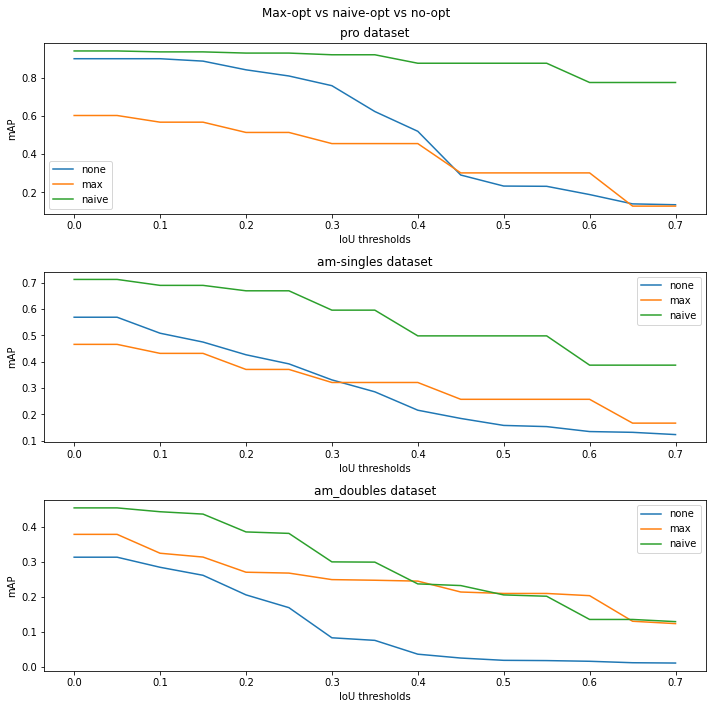

In [20]:
domain_none_pro = np.zeros(len(list_thresh))
domain_max_pro = np.zeros(len(list_thresh))
domain_naive_pro = np.zeros(len(list_thresh))

domain_none_am_singles = np.zeros(len(list_thresh))
domain_max_am_singles = np.zeros(len(list_thresh))
domain_naive_am_singles = np.zeros(len(list_thresh))

domain_none_am_doubles = np.zeros(len(list_thresh))
domain_max_am_doubles = np.zeros(len(list_thresh))
domain_naive_am_doubles = np.zeros(len(list_thresh))

for i, thresh in enumerate(list_thresh):
    domain_none_pro[i] = results_dict[thresh]['domain']['pro']['none']['metrics']['mAP']
    domain_max_pro[i] = results_dict[thresh]['domain']['pro']['max']['metrics']['mAP']
    domain_naive_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['mAP']
    
    domain_none_am_singles[i] = results_dict[thresh]['domain']['am_singles']['none']['metrics']['mAP']
    domain_max_am_singles[i] = results_dict[thresh]['domain']['am_singles']['max']['metrics']['mAP']
    domain_naive_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['mAP']
    
    domain_none_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['none']['metrics']['mAP']
    domain_max_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['max']['metrics']['mAP']
    domain_naive_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['mAP']


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
fig.suptitle('Max-opt vs naive-opt vs no-opt')
ax1.plot(list_thresh, domain_none_pro, label='none')
#ax1.plot(list_thresh, domain_max_pro, label='max')
ax1.plot(list_thresh, domain_naive_pro, label='naive')
ax1.set_title('pro dataset')
ax1.set_xlabel('IoU thresholds')
ax1.set_ylabel('mAP')
ax1.legend()

ax2.plot(list_thresh, domain_none_am_singles, label='none')
ax2.plot(list_thresh, domain_max_am_singles, label='max')
ax2.plot(list_thresh, domain_naive_am_singles, label='naive')
ax2.set_title('am-singles dataset')
ax2.set_xlabel('IoU thresholds')
ax2.set_ylabel('mAP')
ax2.legend()

ax3.plot(list_thresh, domain_none_am_doubles, label='none')
ax3.plot(list_thresh, domain_max_am_doubles, label='max')
ax3.plot(list_thresh, domain_naive_am_doubles, label='naive')
ax3.set_title('am_doubles dataset')
ax3.set_xlabel('IoU thresholds')
ax3.set_ylabel('mAP')
ax3.legend()


plt.tight_layout()

plt.show()

### P1 vs P2

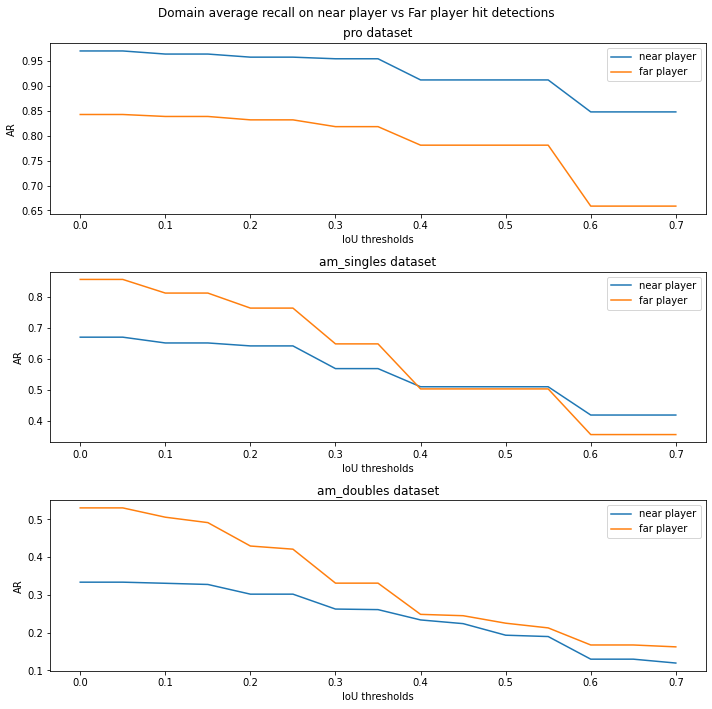

In [21]:
domain_p1_pro = np.zeros(len(list_thresh))
domain_p2_pro = np.zeros(len(list_thresh))

domain_p1_am_singles = np.zeros(len(list_thresh))
domain_p2_am_singles = np.zeros(len(list_thresh))

domain_p1_am_doubles = np.zeros(len(list_thresh))
domain_p2_am_doubles = np.zeros(len(list_thresh))

for i, thresh in enumerate(list_thresh):
    domain_p1_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['AR_1']
    domain_p2_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['AR_2']
    
    domain_p1_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['AR_1']
    domain_p2_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['AR_2']
    
    domain_p1_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['AR_1']
    domain_p2_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['AR_2']
    


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
fig.suptitle('Domain average recall on near player vs Far player hit detections')
ax1.plot(list_thresh, domain_p1_pro, label='near player')
ax1.plot(list_thresh, domain_p2_pro, label='far player')
ax1.set_title('pro dataset')
ax1.set_xlabel('IoU thresholds')
ax1.set_ylabel('AR')
ax1.legend()

ax2.plot(list_thresh, domain_p1_am_singles, label='near player')
ax2.plot(list_thresh, domain_p2_am_singles, label='far player')
ax2.set_title('am_singles dataset')
ax2.set_xlabel('IoU thresholds')
ax2.set_ylabel('AR')
ax2.legend()

ax3.plot(list_thresh, domain_p1_am_doubles, label='near player')
ax3.plot(list_thresh, domain_p2_am_doubles, label='far player')
ax3.set_title('am_doubles dataset')
ax3.set_xlabel('IoU thresholds')
ax3.set_ylabel('AR')
ax3.legend()


plt.tight_layout()

plt.show()

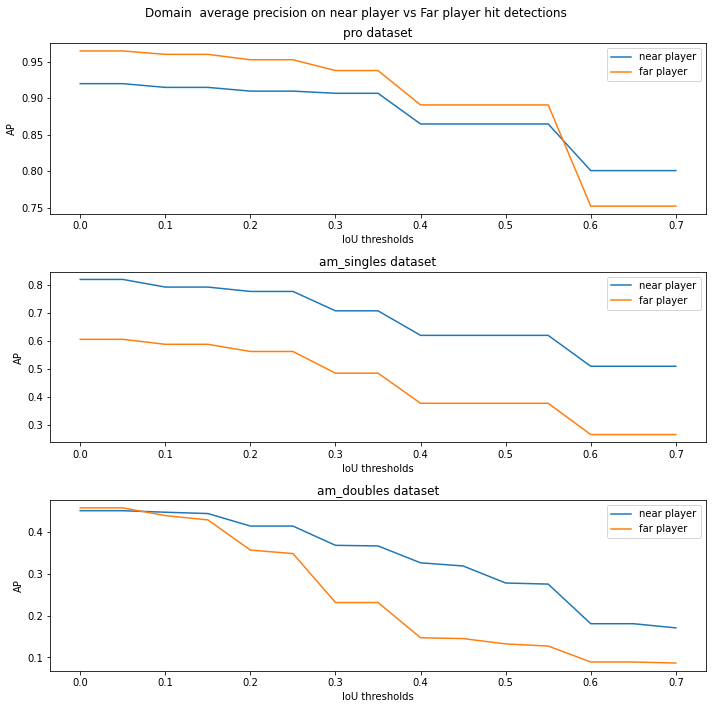

In [22]:
domain_p1_pro = np.zeros(len(list_thresh))
domain_p2_pro = np.zeros(len(list_thresh))

domain_p1_am_singles = np.zeros(len(list_thresh))
domain_p2_am_singles = np.zeros(len(list_thresh))

domain_p1_am_doubles = np.zeros(len(list_thresh))
domain_p2_am_doubles = np.zeros(len(list_thresh))

for i, thresh in enumerate(list_thresh):
    domain_p1_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['AP_1']
    domain_p2_pro[i] = results_dict[thresh]['domain']['pro']['naive']['metrics']['AP_2']
    
    domain_p1_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['AP_1']
    domain_p2_am_singles[i] = results_dict[thresh]['domain']['am_singles']['naive']['metrics']['AP_2']
    
    domain_p1_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['AP_1']
    domain_p2_am_doubles[i] = results_dict[thresh]['domain']['am_doubles']['naive']['metrics']['AP_2']
    


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 10)
fig.suptitle('Domain  average precision on near player vs Far player hit detections')
ax1.plot(list_thresh, domain_p1_pro, label='near player')
ax1.plot(list_thresh, domain_p2_pro, label='far player')
ax1.set_title('pro dataset')
ax1.set_xlabel('IoU thresholds')
ax1.set_ylabel('AP')
ax1.legend()

ax2.plot(list_thresh, domain_p1_am_singles, label='near player')
ax2.plot(list_thresh, domain_p2_am_singles, label='far player')
ax2.set_title('am_singles dataset')
ax2.set_xlabel('IoU thresholds')
ax2.set_ylabel('AP')
ax2.legend()

ax3.plot(list_thresh, domain_p1_am_doubles, label='near player')
ax3.plot(list_thresh, domain_p2_am_doubles, label='far player')
ax3.set_title('am_doubles dataset')
ax3.set_xlabel('IoU thresholds')
ax3.set_ylabel('AP')
ax3.legend()


plt.tight_layout()

plt.show()

## Check performance on best and worst videos

### Function for video visualisation

In [41]:
def vis_pred_onvideo(vidpath, outvidpath, predictions, offset=OFFSET):
  cap = cv2.VideoCapture(vidpath)
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  output = cv2.VideoWriter(outvidpath, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  framenum = 0
  while(True):
    ret, frame = cap.read()
    if(ret):
      if framenum > offset and framenum - offset < len(predictions):
        curr_pred = predictions[framenum - offset]
      else: curr_pred = 0
      
      if curr_pred == 1:
        frame[:,:,0] = 255 # frame turns blue
      elif curr_pred == 2:
        frame[:,:,2] = 255 # frame turns red
        
      if framenum > offset:
        # writing the new frame in output
        output.write(frame)
      
      framenum += 1
    else:
      break
  
  output.release()
  cap.release()

In [48]:
from moviepy.editor import VideoFileClip, clips_array, vfx

def stack_4vids(vidpath1, vidpath2, vidpath3, vidpath4, output_path):
    clip1 = VideoFileClip(vidpath1)
    clip2 = VideoFileClip(vidpath2)
    clip3 = VideoFileClip(vidpath3)
    clip4 = VideoFileClip(vidpath4)
    
    final_clip = clips_array([[clip1, clip2],
                          [clip3, clip4]])
    final_clip.resize(width=960).write_videofile(output_path)

### Best and worst videos

In [24]:
thresh = 0.2

df_domain_naive_pro = results_dict[thresh]['domain']['pro']['naive']['df'].sort_values(by=['P1'])
df_resnet_naive_pro = results_dict[thresh]['resnet']['pro']['naive']['df'].sort_values(by=['P1'])
df_rule_naive_pro = results_dict[thresh]['rulebased']['pro']['naive']['df'].sort_values(by=['P1'])
    
df_domain_naive_am_singles = results_dict[thresh]['domain']['am_singles']['naive']['df'].sort_values(by=['P1'])
df_resnet_naive_am_singles = results_dict[thresh]['resnet']['am_singles']['naive']['df'].sort_values(by=['P1'])
df_rule_naive_am_singles = results_dict[thresh]['rulebased']['am_singles']['naive']['df'].sort_values(by=['P1'])
    
df_domain_naive_am_doubles = results_dict[thresh]['domain']['am_doubles']['naive']['df'].sort_values(by=['P1'])
df_resnet_naive_am_doubles = results_dict[thresh]['resnet']['am_doubles']['naive']['df'].sort_values(by=['P1'])
df_rule_naive_am_doubles = results_dict[thresh]['rulebased']['am_doubles']['naive']['df'].sort_values(by=['P1'])

In [25]:
print("Worst on pro")
print("domain")
print(df_domain_naive_pro.head(2))

print("resnet")
print(df_resnet_naive_pro.head(2))

print("rulebased")
print(df_rule_naive_pro.head(2))

print('-------------------------------------------')
print("Worst on am_singles")
print("domain")
print(df_domain_naive_am_singles.head(7))

print("resnet")
print(df_resnet_naive_am_singles.head(7))

print("rulebased")
print(df_rule_naive_am_singles.head(7))

print('-------------------------------------------')
print("Worst on am_doubles")
print("domain")
print(df_domain_naive_am_doubles.head(8))

print("resnet")
print(df_resnet_naive_am_doubles.head(5))

print("rulebased")
print(df_rule_naive_am_doubles.head(8))

Worst on pro
domain
          match      vid        P1   P2        R1   R2    F1        F2
25  test_match3  1_08_09  0.500000  1.0  0.500000  0.5  0.50  0.666667
13  test_match2  1_11_11  0.571429  0.7  0.727273  0.7  0.64  0.700000
resnet
         match      vid   P1    P2   R1        R2   F1        F2
4  test_match1  1_07_04 -1.0  0.00  0.0 -1.000000  0.0  0.000000
0  test_match1  1_05_02  0.0  0.25  0.0  0.285714  0.0  0.266667
rulebased
         match      vid   P1   P2   R1   R2   F1   F2
8  test_match1  2_02_07 -1.0 -1.0  0.0  0.0  0.0  0.0
4  test_match1  1_07_04  0.0  1.0  0.0  1.0  0.0  1.0
-------------------------------------------
Worst on am_singles
domain
           match       vid        P1        P2        R1        R2        F1  \
17       match25   1_05_03 -1.000000  0.000000  0.000000 -1.000000  0.000000   
1        match24   1_01_01 -1.000000  1.000000  0.000000  1.000000  0.000000   
19       match26   1_00_01 -1.000000  1.000000  0.000000  1.000000  0.000000   
32

In [26]:
print("Best on pro")
print("domain")
print(df_domain_naive_pro.tail(7))

print("resnet")
print(df_resnet_naive_pro.tail(2))

print("rulebased")
print(df_rule_naive_pro.tail(2))

print('-------------------------------------------')
print("Best on am_singles")
print("domain")
print(df_domain_naive_am_singles.tail(5))

print("resnet")
print(df_resnet_naive_am_singles.tail(2))

print("rulebased")
print(df_rule_naive_am_singles.tail(5))

print('-------------------------------------------')
print("Best on am_doubles")
print("domain")
print(df_domain_naive_am_doubles.tail(2))

print("resnet")
print(df_resnet_naive_am_doubles.tail(2))

print("rulebased")
print(df_rule_naive_am_doubles.tail(5))

Best on pro
domain
          match      vid   P1   P2   R1    R2   F1        F2
6   test_match1  1_09_06  1.0  1.0  1.0  1.00  1.0  1.000000
4   test_match1  1_07_04  1.0  1.0  1.0  1.00  1.0  1.000000
3   test_match1  1_07_03  1.0  1.0  1.0  0.80  1.0  0.888889
2   test_match1  1_06_03  1.0  1.0  1.0  0.60  1.0  0.750000
1   test_match1  1_05_03  1.0  1.0  1.0  1.00  1.0  1.000000
26  test_match3  1_09_15  1.0  1.0  1.0  1.00  1.0  1.000000
27  test_match3  1_10_16  1.0  1.0  1.0  0.75  1.0  0.857143
resnet
          match      vid        P1        P2        R1   R2        F1  \
26  test_match3  1_09_15  0.500000  0.000000  1.000000  0.0  0.666667   
7   test_match1  1_09_07  0.636364  0.142857  0.636364  0.2  0.636364   

          F2  
26  0.000000  
7   0.166667  
rulebased
          match      vid   P1   P2        R1   R2   F1   F2
12  test_match2  1_04_04  1.0 -1.0  0.666667  0.0  0.8  0.0
6   test_match1  1_09_06  1.0  1.0  1.000000  1.0  1.0  1.0
-------------------------------

### Select videos for analysis

In [37]:
# pro
p1 = 'pro/test_match1/1_05_02' ## perfect for domain only, detect no hit even when player move halfway to hit

# am_singles
as1 = 'am_singles/match24/1_05_05' ## easy
as2 = 'am_singles/match_china2/singles3' ## domain mix up near and far players
as3 = 'am_singles/match_yewtee/singles0' ## domain bad and mix up near and far players due to angle, moderate for rulesbased


# am_doubles
ad1 = 'am_doubles/match_china/doubles2' ## pretty decent, moderate for domain, rulebased, see if got difference in detections
ad2 = 'am_doubles/match_yewtee/doubles2' ## shuttlecock blocked, but domain still can predict hit, while rule cannot
ad3 = 'am_doubles/match_clementi/doubles5' ## pretty decent
ad4 = 'am_doubles/match_msia/doubles3' ## domain able to pick up hit when pose not present

test_vids = [p1, as1, as2, as3, ad1, ad2, ad3, ad4]

In [38]:
def doubles_probs2labels(rootdir, prefix, matchdir, basename, opt):
    probfile1 = os.path.join(rootdir, prefix, matchdir, basename + '_pair1_probs.npy')
    probfile2 = os.path.join(rootdir, prefix, matchdir, basename + '_pair2_probs.npy')

    if rootdir == RESNET_ROOTDIR:
        pred_labels1 = resnet_probs2labels(probfile1, opt=opt, conf_thresh=CONF_THRESH)
        pred_labels2 = resnet_probs2labels(probfile2, opt=opt, conf_thresh=CONF_THRESH)
    elif rootdir == DOMAIN_ROOTDIR:
        pred_labels1 = domain_probs2labels(probfile1, opt=opt, conf_thresh=CONF_THRESH)
        pred_labels2 = domain_probs2labels(probfile2, opt=opt, conf_thresh=CONF_THRESH)

    pred_labels = []
    for i in range(len(pred_labels1)):
        y1, y2 = pred_labels1[i], pred_labels2[i]
        if (y1 == 1 and y2 == 0) or (y1 == 0 and y2 == 1) or (y1 == 1 and y2 == 1):
            pred_labels.append(1)
        elif (y1 == 2 and y2 == 0) or (y1 == 0 and y2 == 2)  or (y1 == 2 and y2 == 2):
            pred_labels.append(2)
        else:
            pred_labels.append(0)
            
    return pred_labels

In [50]:
opt = 'naive'
outdir = 'demo/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

for test_vid in test_vids:
    print(test_vid)
    prefix, matchdir, basename = test_vid.split('/')
    labelfile = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
    gt_labels = gtfile2labels(labelfile)
    gt_labels = gt_labels[OFFSET:] # offset because domain predictions lose the first 13 frames
    gt_labels = expand_label_frame_range(gt_labels, frame_range=FRAME_RANGE)
    
    shuttle_file = os.path.join(SHUTTLE_ROOTDIR, prefix, matchdir, 'ball_trajectory', basename + '_ball.csv')
    pred_labels_rule = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
    
    if 'doubles' not in prefix:
        probfile_dom = os.path.join(DOMAIN_ROOTDIR, prefix, matchdir, basename + '_probs.npy')
        probfile_resnet = os.path.join(RESNET_ROOTDIR, prefix, matchdir, basename + '_probs.npy')
        pred_labels_dom = domain_probs2labels(probfile_dom, opt=opt, conf_thresh=CONF_THRESH)
        pred_labels_resnet = resnet_probs2labels(probfile_resnet, opt=opt, conf_thresh=CONF_THRESH)
    
    else:
        pred_labels_dom = doubles_probs2labels(DOMAIN_ROOTDIR, prefix, matchdir, basename, opt)
        pred_labels_resnet = doubles_probs2labels(RESNET_ROOTDIR, prefix, matchdir, basename, opt)
    
    vidpath = os.path.join(LABEL_ROOTDIR, prefix, matchdir, 'rally_video', basename + '.mp4')
    out1 = os.path.join(outdir, '_'.join([matchdir, basename, 'dom']) + '.mp4') 
    out2 = os.path.join(outdir, '_'.join([matchdir, basename, 'resnet']) + '.mp4') 
    out3 = os.path.join(outdir, '_'.join([matchdir, basename, 'rule']) + '.mp4') 
    out4 = os.path.join(outdir, '_'.join([matchdir, basename, 'gt']) + '.mp4') 
    
    vis_pred_onvideo(vidpath, out1, pred_labels_dom, offset=OFFSET)
    vis_pred_onvideo(vidpath, out2, pred_labels_resnet, offset=OFFSET)
    vis_pred_onvideo(vidpath, out3, pred_labels_rule, offset=OFFSET)
    vis_pred_onvideo(vidpath, out4, gt_labels, offset=OFFSET)
    
    #output_path = os.path.join(outdir, '_'.join([matchdir, basename, 'concat']) + '.mp4') 
    #stack_4vids(out1, out2, out3, out4, output_path)

pro/test_match1/1_05_02
am_singles/match24/1_05_05
am_singles/match_china2/singles3
am_singles/match_yewtee/singles0
am_doubles/match_china/doubles2
am_doubles/match_yewtee/doubles2
am_doubles/match_clementi/doubles5
am_doubles/match_msia/doubles3
